In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g7qHzHu-MZ16ISKE_SyL-GnMmyyPHRFXwmjgBF0VGYlMUu00G34UY8


In [ ]:
#Camera capture snippet from Google Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 128)        

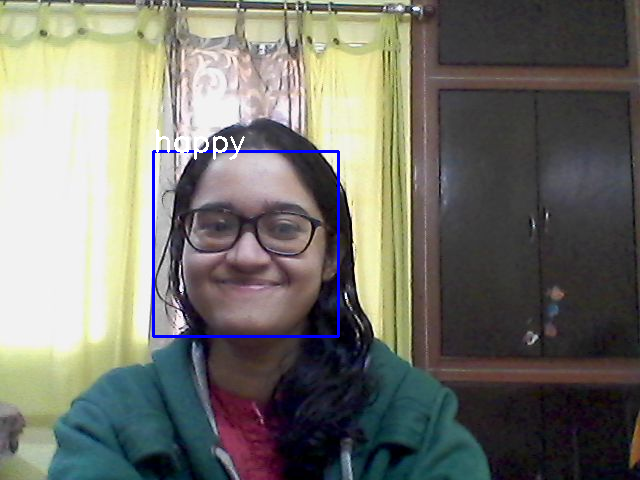

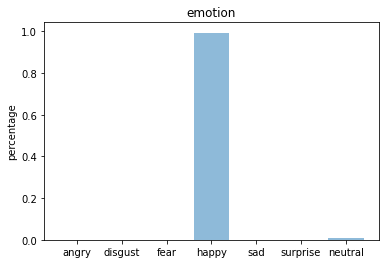

In [ ]:
#LOAD SAVED MODEL AND EXECUTE
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow import keras
from google.colab.patches import cv2_imshow
#-----------------------------
#opencv initialization
def emotion_analysis(emotions):
 objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
 y_pos = np.arange(len(objects))
 
 plt.bar(y_pos, emotions, align='center', alpha=0.5)
 plt.xticks(y_pos, objects)
 plt.ylabel('percentage')
 plt.title('emotion')
 
 plt.show()

#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') THIS IS THE OLD WAY OF LOADING THE FILE, UPDATED TO LATEST PRACTICES OF LOCATING THE XML FILE
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#cap = cv2.VideoCapture('friends.mkv')
#-----------------------------
#face expression recognizer initialization
from keras.models import model_from_json
#Put path name to .pb file being used
model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/emotionRec/saved_model/my_model")
print(model.summary())
#-----------------------------

emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

img = cv2.imread('/content/photo.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

#print(faces) #locations of detected faces

for (x,y,w,h) in faces:
 cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image
 detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
 detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
 detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
		
 img_pixels = image.img_to_array(detected_face)
 img_pixels = np.expand_dims(img_pixels, axis = 0)
		
 img_pixels /= 255 #pixels are in scale of [0, 255]. normalize all pixels in scale of [0, 1]
 predictions = model.predict(img_pixels) #store probabilities of 7 expressions
		
		#find max indexed array 0: angry, 1:disgust, 2:fear, 3:happy, 4:sad, 5:surprise, 6:neutral
 max_index = np.argmax(predictions[0])
 emotion = emotions[max_index]
		
		#write emotion text above rectangle
 cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
 #cv2.imshow('img',img) Cannot use imshow in colab, causes notebook to crash, instead use the patch function
 cv2_imshow(img)
 emotion_analysis(predictions[0])
cv2.waitKey(0)
cv2.destroyAllWindows()